In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [2]:
# Fungsi untuk mencocokkan gambar asli dan mask berdasarkan nomor urutnya
def match_files(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    matched_images = []
    matched_masks = []

    for img_file in image_files:
        num_part = img_file.split('_')[-1]  # Ambil bagian angka dari nama file
        mask_file = f"mask_CLAHE_{num_part}"  # Buat nama mask yang sesuai
        
        if mask_file in mask_files:
            matched_images.append(img_file)
            matched_masks.append(mask_file)
    
    return matched_images, matched_masks

In [3]:
# Fungsi untuk membaca gambar dan mask
def load_images(imgsort, masksort, image_dir, mask_dir):
    images, masks = [], []

    for img, msk in tqdm(zip(imgsort, masksort), total=len(imgsort), desc='Loading Images and Masks'):
        image_path = os.path.join(image_dir, img)
        mask_path = os.path.join(mask_dir, msk)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            print(f"Warning: Failed to load {img} or {msk}")
            continue

        image = cv2.resize(image, (256, 256)) / 255.0  # Normalisasi gambar
        mask = cv2.resize(mask, (256, 256)) / 255.0  # Normalisasi mask (biner: 0 dan 1)
        mask = np.expand_dims(mask, axis=-1)  # Tambahkan dimensi channel untuk keras

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [4]:
# Definisi Encoder Block
def encoder_block(filters, inputs):
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(inputs)
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    p = MaxPooling2D((2,2), padding='same')(x)
    return x, p

# Definisi Baseline Layer
def baseline_layer(filters, inputs):
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(inputs)
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    return x

# Definisi Decoder Block
def decoder_block(filters, skip, inputs):
    x = Conv2DTranspose(filters, (2,2), strides=2, padding='same', activation='relu')(inputs)
    x = concatenate([x, skip], axis=-1)
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    return x

# Fungsi untuk membangun model U-Net
def unet():
    inputs = Input((256, 256, 1))

    s1, p1 = encoder_block(64, inputs)
    s2, p2 = encoder_block(128, p1)
    s3, p3 = encoder_block(256, p2)
    s4, p4 = encoder_block(512, p3)

    baseline = baseline_layer(1024, p4)

    d1 = decoder_block(512, s4, baseline)
    d2 = decoder_block(256, s3, d1)
    d3 = decoder_block(128, s2, d2)
    d4 = decoder_block(64, s1, d3)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(d4)

    return Model(inputs, outputs)

In [5]:
# Load dataset
image_dir = "data_enhancement"
mask_dir = "data_mask"

imgsort, masksort = match_files(image_dir, mask_dir)
images, masks = load_images(imgsort, masksort, image_dir, mask_dir)

Loading Images and Masks: 100%|██████████| 851/851 [00:27<00:00, 30.47it/s]


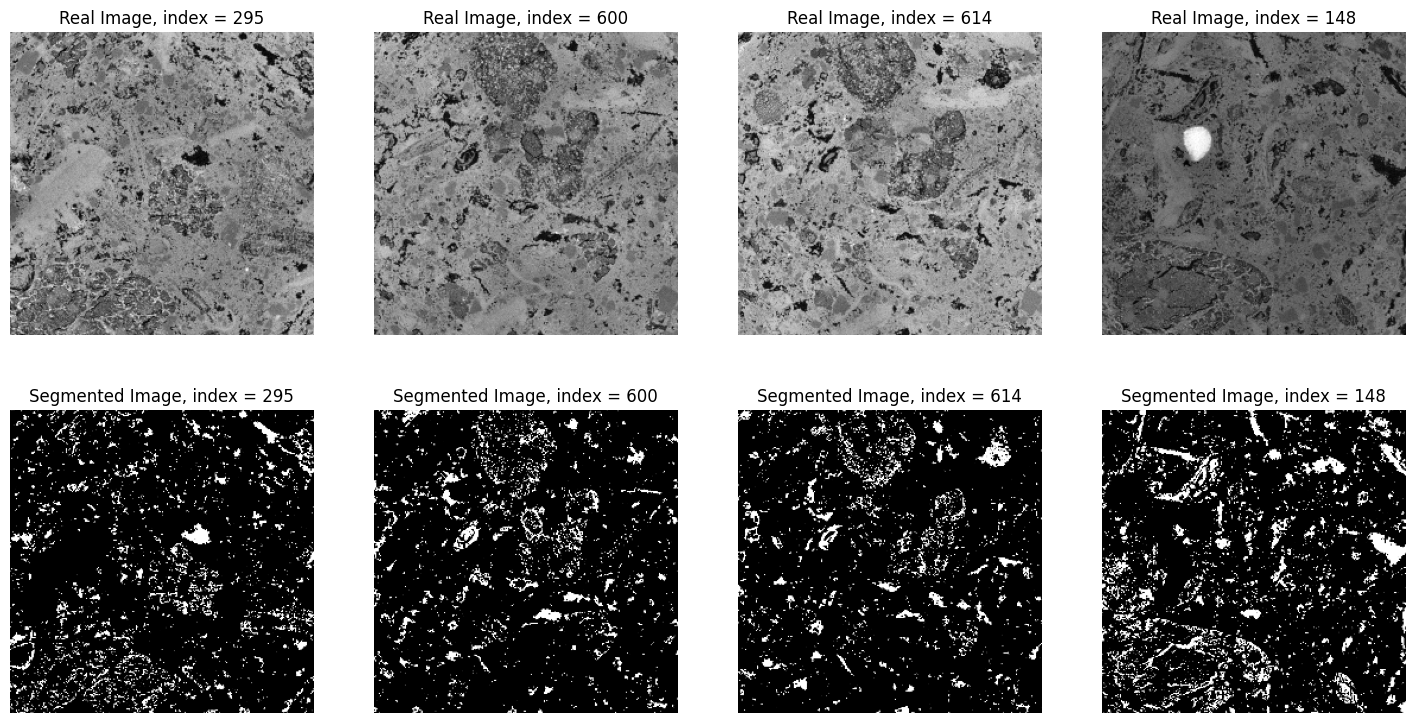

In [6]:
# Fungsi untuk plotting gambar dan mask
def plot_image_with_mask(image_list, mask_list, num_pairs=4):
    plt.figure(figsize=(18,9))
    for i in range(num_pairs):
        idx = random.randint(0, len(image_list) - 1)
        img = image_list[idx]
        mask = mask_list[idx].squeeze()  # Hapus dimensi tambahan
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')

        plt.subplot(2, 4, i + num_pairs + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')

plot_image_with_mask(images, masks, num_pairs=4)

In [7]:
# Fungsi Dice Coefficient
def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    return (2. * intersection + smooth) / (union + smooth)

In [8]:
# Kompilasi Model
unet_model = unet()
unet_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy', dice_coeff])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Data split (contoh sederhana)
split_idx = int(len(images) * 0.8)
train_data = (images[:split_idx], masks[:split_idx])
val_data = (images[split_idx:], masks[split_idx:])

# Training model
unet_history = unet_model.fit(
    train_data[0], train_data[1],
    validation_data=(val_data[0], val_data[1]),
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_14/Relu' defined at (most recent call last):
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mrees\AppData\Local\Temp\ipykernel_18220\1316222409.py", line 16, in <module>
      unet_history = unet_model.fit(
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\mrees\anaconda3\envs\tfgpu\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_14/Relu'
OOM when allocating tensor with shape[128,256,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_14/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3085]

In [ ]:
# Fungsi untuk melihat hasil prediksi
def plot_preds(idx):
    plt.figure(figsize=(15, 15))
    test_img = np.expand_dims(images[idx], axis=(0, -1))  # Tambahkan batch dan channel
    pred = unet_model.predict(test_img).squeeze()
    pred = pred > 0.5  # Thresholding

    plt.subplot(1,3,1)
    plt.imshow(images[idx], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(masks[idx].squeeze(), cmap='gray')
    plt.title('Actual Mask')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

# Plot hasil prediksi untuk beberapa gambar
for i in [random.randint(0, len(images)-1) for _ in range(4)]:
    plot_preds(i)